# 1. 环境配置

建议在仓库根目录使用虚拟环境，并通过 requirements.txt 安装依赖：

1) 创建与激活虚拟环境（Windows PowerShell）

    python -m venv .venv
    .\.venv\Scripts\Activate.ps1

2) 安装依赖

    pip install -U pip
    pip install -r requirements.txt

下方单元将仅做依赖导入与版本打印，避免在 Notebook 内动态安装导致环境不一致。

In [1]:
# 依赖导入与版本打印（请先按 README 使用 requirements.txt 安装依赖）
import importlib
import sys

modules = ["pandas", "matplotlib", "numpy"]
missing = []
for m in modules:
    if importlib.util.find_spec(m) is None:
        missing.append(m)

if missing:
    raise ModuleNotFoundError(
        f"缺少依赖: {missing}。请先在仓库根目录执行 'pip install -r requirements.txt' 并确保已激活虚拟环境。"
    )

import pandas as pd
import matplotlib
import numpy as np

print(
    "Python:", sys.version.split(" ")[0],
    "| pandas:", pd.__version__,
    "| matplotlib:", matplotlib.__version__,
    "| numpy:", np.__version__,
)

Python: 3.13.7 | pandas: 2.3.2 | matplotlib: 3.10.6 | numpy: 2.3.3


# 2. 数据导入并筛选

数据文件位于当前目录：`hyglike_from_athyg_v32.csv.gz`。若需要移动文件，请同步更新代码中的 `file_path`。

In [2]:
# 导入依赖（已在上文校验）
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# 文件名直接使用 .csv.gz 后缀
file_path = Path('hyglike_from_athyg_v32.csv.gz')

# 读取所需列，提升稳健性与速度
required_cols = {"mag", "ci", "x", "y"}
try:
    df = pd.read_csv(file_path, usecols=list(required_cols))
except FileNotFoundError:
    raise FileNotFoundError(
        f"未找到数据文件: {file_path.resolve()}\n"
        "请确认文件位于 StarAtlas/ 目录内，或更新 file_path 为正确路径。"
    )

# 校验必需列
missing_cols = required_cols.difference(df.columns)
if missing_cols:
    raise ValueError(
        f"数据缺少必要列: {sorted(missing_cols)}，实际列为: {sorted(df.columns.tolist())}"
    )

# 将相关列转为数值，非法值转为 NaN
num_cols = ["mag", "ci", "x", "y"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 过滤无穷值及 NaN
before = len(df)
mask_finite = np.isfinite(df[num_cols]).all(axis=1)
df = df[mask_finite].copy()
filtered_inf_nan = before - len(df)

# 视星等范围剪裁，避免极端值造成点尺寸异常
# 常见可视范围：mag [-1, 10]，后续仍会筛选 <6 的明亮星
df["mag"] = df["mag"].clip(lower=-1, upper=10)

# 筛选数据：只保留视星等小于6的恒星
stars_df = df[df['mag'] < 6].copy()

# 丢弃没有色指数（ci）的恒星，以确保颜色映射正常
stars_df.dropna(subset=['ci'], inplace=True)

# 色指数常见范围近似 [-0.5, 2.0]，超界值剪裁以稳定配色
stars_df["ci"] = stars_df["ci"].clip(lower=-0.5, upper=2.0)

# 创建绘图安全列：尺寸与颜色映射所用
size_base = 8.0
size_exponent = 2.5
stars_df["mag_for_size"] = (size_base - stars_df["mag"]).clip(lower=0.1) ** size_exponent
stars_df["ci_for_color"] = stars_df["ci"]

# 清洗摘要日志
if stars_df.empty:
    raise ValueError(
        "筛选后用于绘图的数据为空：请检查 'mag < 6' 的阈值、必需列及数据质量。"
    )

print(
    "数据加载与清洗完成：",
    f"原始记录 {before} 行；",
    f"去除 NaN/Inf {filtered_inf_nan} 行；",
    f"用于绘图 {len(stars_df)} 行。",
)

数据加载与清洗完成： 原始记录 118971 行； 去除 NaN/Inf 1740 行； 用于绘图 4988 行。


## 2.1 可选：边缘数据过滤（分位数/椭圆裁剪）

为降低边缘畸变或边界数据造成的聚集感，可对 `x/y` 做分位数裁剪或按椭圆区域进行裁剪，只保留主要区域用于绘图。下面单元提供可配置参数。

In [3]:
# 可选过滤：分位数和椭圆裁剪（按需启用）
use_quantile_crop = True
quantile_low = 0.01
quantile_high = 0.99

use_ellipse_crop = False
ellipse_scale_x = 0.95  # 椭圆半轴相对数据范围的比例
ellipse_scale_y = 0.95

plot_df = stars_df.copy()

# 分位数裁剪：去掉最外侧 1% 与 99% 之外的数据
if use_quantile_crop:
    x_low, x_high = plot_df['x'].quantile([quantile_low, quantile_high])
    y_low, y_high = plot_df['y'].quantile([quantile_low, quantile_high])
    plot_df = plot_df[(plot_df['x'].between(x_low, x_high)) & (plot_df['y'].between(y_low, y_high))].copy()

# 椭圆裁剪：以数据中心为圆心，按椭圆半轴过滤
if use_ellipse_crop and not plot_df.empty:
    x_min, x_max = plot_df['x'].min(), plot_df['x'].max()
    y_min, y_max = plot_df['y'].min(), plot_df['y'].max()
    cx, cy = (x_min + x_max) / 2, (y_min + y_max) / 2
    rx = (x_max - x_min) * ellipse_scale_x / 2
    ry = (y_max - y_min) * ellipse_scale_y / 2
    if rx > 0 and ry > 0:
        nx = (plot_df['x'] - cx) / rx
        ny = (plot_df['y'] - cy) / ry
        inside = (nx**2 + ny**2) <= 1.0
        plot_df = plot_df[inside].copy()

if plot_df.empty:
    raise ValueError("应用边缘过滤后没有可绘制数据，请调整过滤参数或关闭过滤开关。")

print(f"过滤后用于绘图的数据量：{len(plot_df)} 行（原始 {len(stars_df)} 行）")

过滤后用于绘图的数据量：4822 行（原始 4988 行）


# 3. 开始绘画

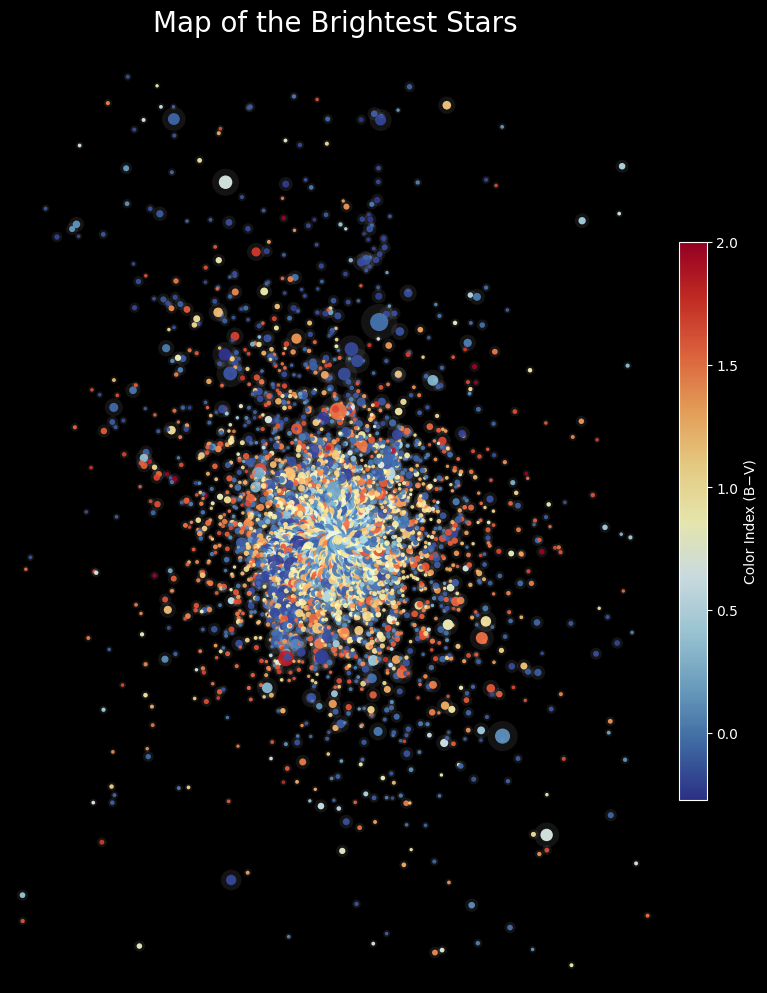

In [9]:
# --- 步骤五：可视化 ---

# 1. 配置参数（如需调整可修改以下数值）
plt.style.use('dark_background')
figsize = (12, 12)
size_multiplier = 1.0
glow_scale = 4.0
glow_alpha = 0.08
point_alpha = 0.9
cmap = 'RdYlBu_r'
add_colorbar = True
margin_ratio = 0.02  # 2% 边距，避免裁边

# 2. 创建画布
fig, ax = plt.subplots(figsize=figsize)

# 3. 计算大小 (使用预处理列 mag_for_size)
sizes = plot_df['mag_for_size'] * size_multiplier

# 4. 添加辉光效果 (底层)
ax.scatter(
    plot_df['x'],
    plot_df['y'],
    s=sizes * glow_scale,  # 辉光比星点大
    c='white',
    alpha=glow_alpha,
    edgecolors='none'
)

# 5. 绘制星星本身 (上层)
scatter = ax.scatter(
    plot_df['x'],
    plot_df['y'],
    s=sizes,
    c=plot_df['ci_for_color'],  # 使用预处理后的色指数
    cmap=cmap,
    alpha=point_alpha,
    edgecolors='none'
)

# 可选 colorbar
if add_colorbar:
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Color Index (B−V)")

# 6. 美化调整 + 边距
xmin, xmax = plot_df['x'].min(), plot_df['x'].max()
ymin, ymax = plot_df['y'].min(), plot_df['y'].max()
px = (xmax - xmin) * margin_ratio
py = (ymax - ymin) * margin_ratio
ax.set_xlim(xmin - px, xmax + px)
ax.set_ylim(ymin - py, ymax + py)
ax.set_aspect('equal')  # 保证X和Y轴比例相同，星图不会变形
ax.axis('off')  # 关闭坐标轴、刻度和边框

plt.title("Map of the Brightest Stars", fontsize=20, color='white', pad=20)

# 显示图像（如需保存，可参考下行注释）
plt.show()
# fig.savefig("my_star_map.png", dpi=300, bbox_inches='tight', pad_inches=0)

# 4. 交互可视化（Bokeh）

本节使用 Bokeh 提供“滚轮缩放 + 拖拽平移 + 悬浮提示 + 重置视图”的交互体验，默认将滚轮设置为缩放、拖拽为平移，并提供工具栏的重置按钮。

In [ ]:
# Bokeh 交互星图（滚轮缩放、拖拽平移、悬浮提示、重置视图）
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import RdYlBu11 as palette
import numpy as np

# 在 Notebook 中内嵌渲染
output_notebook()

# 点大小作为数据列加入数据源（避免与 source 同时传入独立序列导致的错误）
size_scale = 1.0
plot_df = plot_df.copy()
plot_df["size"] = (plot_df["mag_for_size"].to_numpy() * size_scale)

# 数据源：使用前面过滤后的 plot_df
src = ColumnDataSource(plot_df)

# 颜色映射（与 matplotlib 的 RdYlBu_r 接近：这里取 RdYlBu11 并反转）
colors = list(reversed(palette))
low = float(plot_df["ci_for_color"].min())
high = float(plot_df["ci_for_color"].max())
color_mapper = LinearColorMapper(palette=colors, low=low, high=high)

# 初始视窗：在当前数据范围上加少量边距
xmin, xmax = float(plot_df['x'].min()), float(plot_df['x'].max())
ymin, ymax = float(plot_df['y'].min()), float(plot_df['y'].max())
mx = (xmax - xmin) * 0.02
my = (ymax - ymin) * 0.02

p = figure(
    width=900, height=900, match_aspect=True,
    tools="pan,wheel_zoom,box_zoom,reset,save",
    active_scroll="wheel_zoom",  # 滚轮缩放
    active_drag="pan",            # 拖拽平移
    x_range=(xmin - mx, xmax + mx),
    y_range=(ymin - my, ymax + my),
    title="Interactive Map of the Brightest Stars (Bokeh)"
)

# 关闭坐标轴与网格，保持暗背景风格
p.axis.visible = False
p.grid.visible = False

# 绘制散点（size 使用字段名）
renderer = p.scatter(
    x="x", y="y", source=src,
    size="size",
    fill_color={"field": "ci_for_color", "transform": color_mapper},
    line_color=None, fill_alpha=0.9
)

# 悬浮提示（hover）：显示 mag 与 ci，可按需添加更多字段
hover = HoverTool(
    tooltips=[
        ("x", "@x{0.000}"),
        ("y", "@y{0.000}"),
        ("mag", "@mag"),
        ("ci", "@ci_for_color")
    ],
    renderers=[renderer]
)
p.add_tools(hover)

# 颜色条
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8)
p.add_layout(color_bar, "right")

show(p)

Loading BokehJS ...

RuntimeError: 

Expected size to reference fields in the supplied data source.

When a 'source' argument is passed to a glyph method, values that are sequences
(like lists or arrays) must come from references to data columns in the source.

For instance, as an example:

    source = ColumnDataSource(data=dict(x=a_list, y=an_array))

    p.scatter(x='x', y='y', source=source, ...) # pass column names and a source

Alternatively, *all* data sequences may be provided as literals as long as a
source is *not* provided:

    p.scatter(x=a_list, y=an_array, ...)  # pass actual sequences and no source

